In [48]:
import sys 
sys.path.append('..')
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
test_path = "../Datasets/PadJSRTClassification/test"
train_path = "../Datasets/PadJSRTClassification/train"
val_path = "../Datasets/PadJSRTClassification/val"

In [50]:
import os 

import torch
from torchvision import transforms
import numpy as np

import pathlib
import re

from utils.dataLoader import LandmarksDataset, ToTensor, Rescale
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH

In [51]:
import os
from utils.dataLoader import LandmarksDataset, ToTensor, Rescale


img_path = os.path.join(train_path, 'Images')
label_path = os.path.join(train_path, 'landmarks')
train_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensor()])
                                 )
img_path = os.path.join(val_path, 'Images')
label_path = os.path.join(val_path, 'landmarks')
val_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensor()])
                                 )
img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensor()])
                                 )

In [52]:
# get list of all landmarks
train_image = []
train_landmarks = []

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    train_image.append(sample['image'])
    train_landmarks.append(sample['landmarks'][:120])

val_image = []
val_landmarks = []

for i in range(len(val_dataset)):
    sample = val_dataset[i]
    val_image.append(sample['image'])
    val_landmarks.append(sample['landmarks'][:120])

test_image = []
test_landmarks = []

for i in range(len(test_dataset)):
    sample = test_dataset[i]
    test_image.append(sample['image'])
    test_landmarks.append(sample['landmarks'][:120])

In [54]:
train_landmarks = torch.stack(train_landmarks)
val_landmarks = torch.stack(val_landmarks)
test_landmarks = torch.stack(test_landmarks)

print(train_landmarks.shape)

torch.Size([70, 120, 2])


In [55]:
train_right_lung = train_landmarks[:,:44,:]
train_left_lung = train_landmarks[:,44:94:,] 
train_heart = train_landmarks[:,94:,:]
print(train_heart.shape)

test_right_lung = test_landmarks[:,:44,:]
test_left_lung = test_landmarks[:,44:94:,]
test_heart = test_landmarks[:,94:,:]

val_right_lung = val_landmarks[:,:44,:]
val_left_lung = val_landmarks[:,44:94:,]
val_heart = val_landmarks[:,94:,:]





torch.Size([70, 26, 2])


In [56]:
# Assuming `right_lung`, `left_lung`, `heart` are your tensors
# lung_min_x = torch.min(torch.min(train_right_lung, dim=1).values, torch.min(train_left_lung, dim=1).values)[:, 0]
# lung_max_x = torch.max(torch.max(train_right_lung, dim=1).values, torch.max(train_left_lung, dim=1).values)[:, 0]

# Assuming the x-coordinates are at index 0 after reshaping
right_lung_x = train_right_lung.view(train_right_lung.shape[0], -1)[:, ::2]
left_lung_x = train_left_lung.view(train_left_lung.shape[0], -1)[:, ::2]

lung_min_x = torch.min(torch.min(right_lung_x, dim=1).values, torch.min(left_lung_x, dim=1).values)
lung_max_x = torch.max(torch.max(right_lung_x, dim=1).values, torch.max(left_lung_x, dim=1).values)

# heart_min_x = torch.min(train_heart, dim=1).values[:, 0]
# heart_max_x = torch.max(train_heart, dim=1).values[:, 0]
heart_min_x = torch.min(train_heart, dim=1).values.view(-1)[::2]
heart_max_x = torch.max(train_heart, dim=1).values.view(-1)[::2]


# Calculate the maximum horizontal distances
lung_distance = lung_max_x - lung_min_x
heart_distance = heart_max_x - heart_min_x

# Calculate CTR
train_CTR = heart_distance / lung_distance


########################################################################################
right_lung_x = test_right_lung.view(test_right_lung.shape[0], -1)[:, ::2]
left_lung_x = test_left_lung.view(test_left_lung.shape[0], -1)[:, ::2]

lung_min_x = torch.min(torch.min(right_lung_x, dim=1).values, torch.min(left_lung_x, dim=1).values)
lung_max_x = torch.max(torch.max(right_lung_x, dim=1).values, torch.max(left_lung_x, dim=1).values)

# lung_min_x = torch.min(torch.min(test_right_lung, dim=1).values, torch.min(test_left_lung, dim=1).values)[:, 0]
# lung_max_x = torch.max(torch.max(test_right_lung, dim=1).values, torch.max(test_left_lung, dim=1).values)[:, 0]

# heart_min_x = torch.min(test_heart, dim=1).values[:, 0]
# heart_max_x = torch.max(test_heart, dim=1).values[:, 0]
heart_min_x = torch.min(test_heart, dim=1).values.view(-1)[::2]
heart_max_x = torch.max(test_heart, dim=1).values.view(-1)[::2]

# Calculate the maximum horizontal distances
lung_distance = lung_max_x - lung_min_x
heart_distance = heart_max_x - heart_min_x

# Calculate CTR
test_CTR = heart_distance / lung_distance

########################################################################################   
right_lung_x = val_right_lung.view(val_right_lung.shape[0], -1)[:, ::2]
left_lung_x = val_left_lung.view(val_left_lung.shape[0], -1)[:, ::2]

lung_min_x = torch.min(torch.min(right_lung_x, dim=1).values, torch.min(left_lung_x, dim=1).values)
lung_max_x = torch.max(torch.max(right_lung_x, dim=1).values, torch.max(left_lung_x, dim=1).values)


# lung_min_x = torch.min(torch.min(val_right_lung, dim=1).values, torch.min(val_left_lung, dim=1).values)[:, 0]
# lung_max_x = torch.max(torch.max(val_right_lung, dim=1).values, torch.max(val_left_lung, dim=1).values)[:, 0]

# heart_min_x = torch.min(val_heart, dim=1).values[:, 0]
# heart_max_x = torch.max(val_heart, dim=1).values[:, 0]
heart_min_x = torch.min(val_heart, dim=1).values.view(-1)[::2]
heart_max_x = torch.max(val_heart, dim=1).values.view(-1)[::2]


# Calculate the maximum horizontal distances
lung_distance = lung_max_x - lung_min_x
heart_distance = heart_max_x - heart_min_x

# Calculate CTR
val_CTR = heart_distance / lung_distance


In [57]:
print("train_CTR", train_CTR)
print("test_ctr", test_CTR)
print("val_CTR", val_CTR)

train_CTR tensor([0.5484, 0.5449, 0.5970, 0.5502, 0.5190, 0.5039, 0.5588, 0.5287, 0.5620,
        0.5903, 0.5611, 0.5052, 0.5299, 0.5314, 0.6757, 0.5141, 0.5629, 0.6209,
        0.5610, 0.5270, 0.5723, 0.5712, 0.5693, 0.5660, 0.5794, 0.5856, 0.5507,
        0.5258, 0.5088, 0.4852, 0.7187, 0.5194, 0.5494, 0.3888, 0.5778, 0.5716,
        0.6329, 0.4114, 0.4499, 0.4571, 0.5724, 0.6082, 0.4642, 0.4243, 0.4112,
        0.4415, 0.4594, 0.4745, 0.4852, 0.4448, 0.4384, 0.4252, 0.4394, 0.4973,
        0.4589, 0.4533, 0.5461, 0.4971, 0.4611, 0.3609, 0.4273, 0.4814, 0.3828,
        0.5435, 0.5433, 0.4281, 0.5247, 0.4868, 0.4465, 0.4733])
test_ctr tensor([0.5576, 0.5072, 0.5042, 0.4264, 0.4252, 0.5319, 0.4962, 0.5660, 0.4983,
        0.4486, 0.4756, 0.5088, 0.4458, 0.5850, 0.3793])
val_CTR tensor([0.5482, 0.5431, 0.5506, 0.5480, 0.4061, 0.5381, 0.4644, 0.5871, 0.4797,
        0.4537, 0.4837, 0.4626, 0.4478, 0.5418, 0.4812])


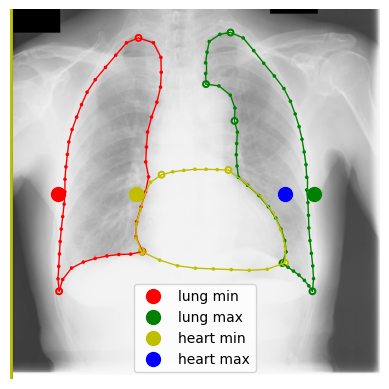

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose the index of the image you're interested in
image_index = 13

lung_image = test_dataset[image_index]['image'][0]

# Assuming the x-coordinates are at even indices and y-coordinates are at odd indices
right_lung_x = test_right_lung[image_index].view(-1)[::2]
left_lung_x = test_left_lung[image_index].view(-1)[::2]

lung_min_x = min(torch.min(right_lung_x), torch.min(left_lung_x))
lung_max_x = max(torch.max(right_lung_x), torch.max(left_lung_x))

# Find min and max for the right lung, left lung, and heart of the chosen image
# lung_min_x = min(torch.min(test_right_lung[image_index].view(-1)), torch.min(test_left_lung[image_index].view(-1)))
# lung_max_x = max(torch.max(test_right_lung[image_index].view(-1)), torch.max(test_left_lung[image_index].view(-1)))

heart_min_x = torch.min(test_heart[image_index].view(-1)[::2])
heart_max_x = torch.max(test_heart[image_index].view(-1)[::2])

# Assuming `lung_image` is your lung image
# plt.imshow(lung_image, cmap='gray')

# Create rectangles for the min and max x-coordinates of the lungs
rect_lung_min = patches.Rectangle((lung_min_x, 0), width=1, height=lung_image.shape[0], linewidth=2, edgecolor='r', facecolor='none')
rect_lung_max = patches.Rectangle((lung_max_x, 0), width=1, height=lung_image.shape[0], linewidth=2, edgecolor='b', facecolor='none')

# Create rectangles for the min and max x-coordinates of the heart
rect_heart_min = patches.Rectangle((heart_min_x, 0), width=1, height=lung_image.shape[0], linewidth=2, edgecolor='g', facecolor='none')
rect_heart_max = patches.Rectangle((heart_max_x, 0), width=1, height=lung_image.shape[0], linewidth=2, edgecolor='y', facecolor='none')

# Add the rectangles to the plot
plt.gca().add_patch(rect_lung_min)
plt.gca().add_patch(rect_lung_max)
plt.gca().add_patch(rect_heart_min)
plt.gca().add_patch(rect_heart_max)

# Set plot limits
plt.xlim(0, lung_image.shape[1])
plt.ylim(lung_image.shape[0], 0)  # Note: y values are inverted in image coordinates

# Plot points for the min and max x-coordinates of the lungs
plt.plot(lung_min_x*1024, lung_image.shape[0] // 2, 'ro', markersize=10, label='lung min')  # red point
plt.plot(lung_max_x*1024, lung_image.shape[0] // 2, 'go', markersize=10, label='lung max')  # blue point

# Plot points for the min and max x-coordinates of the heart
plt.plot(heart_min_x*1024, lung_image.shape[0] // 2, 'yo', markersize=10, label = 'heart min')  # green point
plt.plot(heart_max_x*1024, lung_image.shape[0] // 2, 'bo', markersize=10, label='heart max')  # yellow point
plt.legend()
plt.axis('off')

# Existing code
from utils.fun import drawOrgans
device = torch.device('cpu')

img1 = test_dataset[image_index]['image']
lm = test_dataset[image_index]['landmarks'][:120]

target = lm.reshape(-1).numpy()

data = torch.unsqueeze(img1, 0).to(device)
draw = data.cpu().numpy()[0,0,:,:]
ax = plt.subplot(1, 1, 1)

img2 = drawOrgans(ax, target*1024, None, draw)



In [59]:
print(train_landmarks.shape)

torch.Size([70, 120, 2])


In [60]:
#reshape landmarks
train_landmarks_reshape = train_landmarks.reshape(70,-1)
val_landmarks_reshape = val_landmarks.reshape(15,-1)
test_landmarks_reshape = test_landmarks.reshape(15,-1)
print(train_landmarks_reshape.shape)
print(val_landmarks_reshape.shape)
print(test_landmarks_reshape.shape)

torch.Size([70, 240])
torch.Size([15, 240])
torch.Size([15, 240])


In [61]:
# Regression 
from sklearn.linear_model import LinearRegression
reg_lin = LinearRegression().fit(train_landmarks_reshape, train_CTR)

from sklearn import tree
reg_tree = tree.DecisionTreeRegressor().fit(train_landmarks_reshape, train_CTR)

from sklearn.neural_network import MLPRegressor
reg_mlp = MLPRegressor(random_state=1, max_iter=500).fit(train_landmarks_reshape, train_CTR)

In [62]:
# # import r2 scores
# from sklearn.metrics import r2_score

# #predictions 
# reg_pred = reg_lin.predict(test_landmarks_reshape)
# reg_pred_val = reg_lin.predict(val_landmarks_reshape)

# # r2 scores
# r2 = r2_score(test_CTR, reg_pred)
# r2_val = r2_score(val_CTR, reg_pred_val)
# print('R2:', r2)
# print('R2_val:', r2_val)

# mse = mean_squared_error(test_CTR, reg_pred)
# print('MSE:', mse)

# plt.scatter(test_CTR, reg_pred)
#  # Add boundary line at x=0.5
# plt.xlabel('True CTR')
# plt.ylabel('Predicted CTR from Linear Regression')
# plt.title('Linear Regression')
# plt.show()

R2_test: 0.7989921128554882
R2_val: 0.8710661910983017
MSE test: 0.00062221865


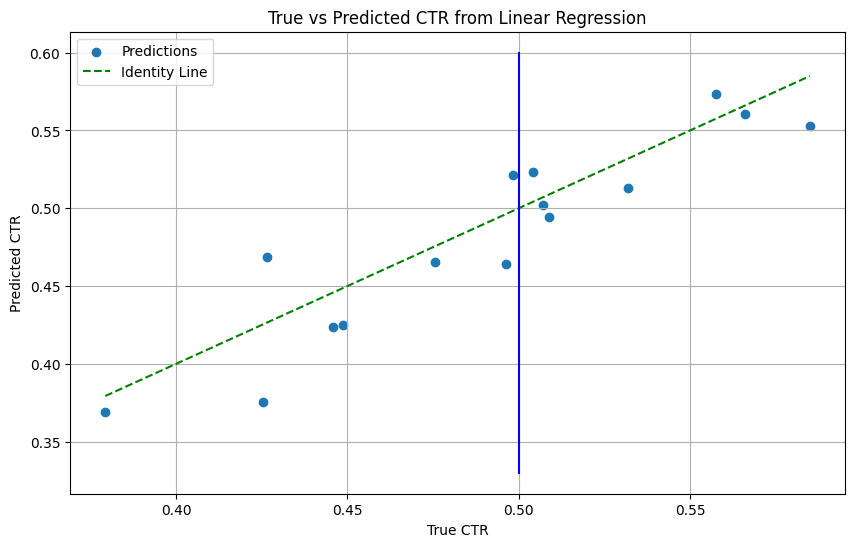

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Assuming reg, test_landmarks_reshape, val_landmarks_reshape, test_CTR, and val_CTR are already defined

reg_pred = reg_lin.predict(test_landmarks_reshape)
reg_pred_val = reg_lin.predict(val_landmarks_reshape)


r2 = r2_score(test_CTR, reg_pred)
r2_val = r2_score(val_CTR, reg_pred_val)
print('R2_test:', r2)
print('R2_val:', r2_val)

mse = mean_squared_error(test_CTR, reg_pred)
print('MSE test:', mse)

plt.figure(figsize=(10, 6))
plt.scatter(test_CTR, reg_pred, label='Predictions')
plt.plot([min(test_CTR), max(test_CTR)], [min(test_CTR), max(test_CTR)], 'g--', label='Identity Line')
plt.plot([0.5, 0.5], [0.33,0.6], 'b')

plt.xlabel('True CTR')
plt.ylabel('Predicted CTR')
plt.title('True vs Predicted CTR from Linear Regression')
plt.legend()
plt.grid(True)
plt.show()


R2_test: 0.7989921128554882
R2_val: 0.8710661910983017
predicitons [0.57362145 0.5018304  0.52335966 0.46892518 0.3757385  0.5128837
 0.46441823 0.56088454 0.5212576  0.42481607 0.46565327 0.49437168
 0.42385542 0.5527079  0.36917627]
true tensor([0.5576, 0.5072, 0.5042, 0.4264, 0.4252, 0.5319, 0.4962, 0.5660, 0.4983,
        0.4486, 0.4756, 0.5088, 0.4458, 0.5850, 0.3793])
MSE: 0.00062221865


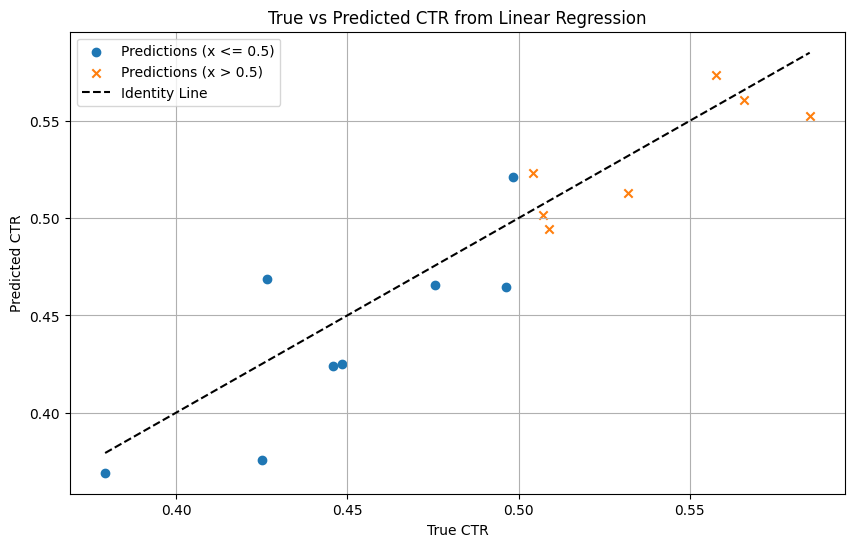

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Assuming reg, test_landmarks_reshape, val_landmarks_reshape, test_CTR, and val_CTR are already defined

# Predictions
reg_pred = reg_lin.predict(test_landmarks_reshape)
reg_pred_val = reg_lin.predict(val_landmarks_reshape)

# R2 scores
r2 = r2_score(test_CTR, reg_pred)
r2_val = r2_score(val_CTR, reg_pred_val)
print('R2_test:', r2)
print('R2_val:', r2_val)
print("predicitons", reg_pred)
print("true", test_CTR)

# Mean Squared Error
mse = mean_squared_error(test_CTR, reg_pred)
print('MSE:', mse)

# Scatter plot of true vs. predicted CTR
plt.figure(figsize=(10, 6))

# Plot points with x values <= 0.5
mask_under_0_5 = test_CTR <= 0.5
plt.scatter(test_CTR[mask_under_0_5], reg_pred[mask_under_0_5], label='Predictions (x <= 0.5)')

# Plot points with x values > 0.5
mask_over_0_5 = test_CTR > 0.5
plt.scatter(test_CTR[mask_over_0_5], reg_pred[mask_over_0_5],  label='Predictions (x > 0.5)', marker='x')

# Plot identity line in black
plt.plot([min(test_CTR), max(test_CTR)], [min(test_CTR), max(test_CTR)], 'k--', label='Identity Line')

plt.xlabel('True CTR')
plt.ylabel('Predicted CTR')
plt.title('True vs Predicted CTR from Linear Regression')
plt.legend()
plt.grid(True)
plt.show()


R2: 0.19607519023765962
R2_val: -1.3098031976460227
predicitons [0.55067736 0.51896542 0.42734122 0.54936373 0.46110663 0.51409239
 0.42734122 0.56096697 0.48679245 0.42734122 0.41122565 0.54327565
 0.38882422 0.56285483 0.38882422]
true tensor([0.5576, 0.5072, 0.5042, 0.4264, 0.4252, 0.5319, 0.4962, 0.5660, 0.4983,
        0.4486, 0.4756, 0.5088, 0.4458, 0.5850, 0.3793])
MSE: 0.002488544343342625


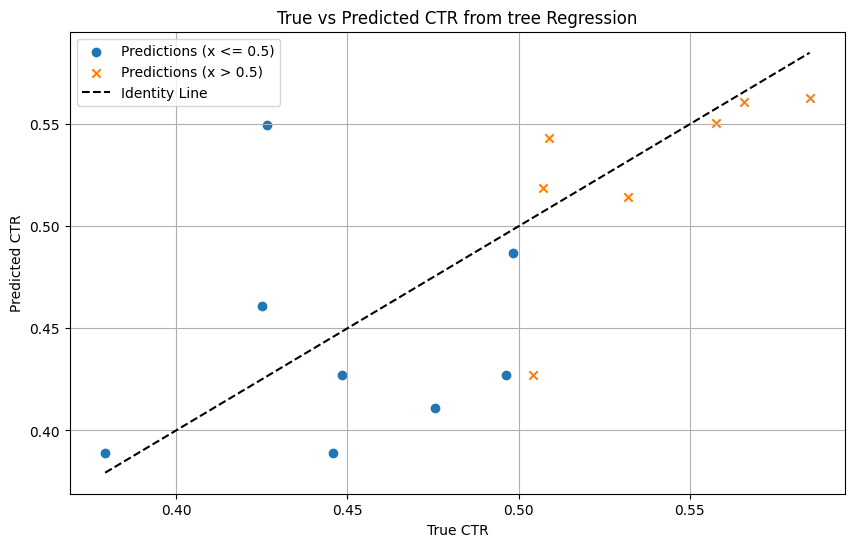

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Assuming reg, test_landmarks_reshape, val_landmarks_reshape, test_CTR, and val_CTR are already defined

# Predictions
reg_pred = reg_tree.predict(test_landmarks_reshape)
reg_pred_val = reg_tree.predict(val_landmarks_reshape)

# R2 scores
r2 = r2_score(test_CTR, reg_pred)
r2_val = r2_score(val_CTR, reg_pred_val)
print('R2:', r2)
print('R2_val:', r2_val)

print("predicitons", reg_pred)
print("true", test_CTR)

# Mean Squared Error
mse = mean_squared_error(test_CTR, reg_pred)
print('MSE:', mse)

# Scatter plot of true vs. predicted CTR
plt.figure(figsize=(10, 6))

# Plot points with x values <= 0.5
mask_under_0_5 = test_CTR <= 0.5
plt.scatter(test_CTR[mask_under_0_5], reg_pred[mask_under_0_5], label='Predictions (x <= 0.5)')

# Plot points with x values > 0.5
mask_over_0_5 = test_CTR > 0.5
plt.scatter(test_CTR[mask_over_0_5], reg_pred[mask_over_0_5],  label='Predictions (x > 0.5)', marker='x')

# Plot identity line in black
plt.plot([min(test_CTR), max(test_CTR)], [min(test_CTR), max(test_CTR)], 'k--', label='Identity Line')

plt.xlabel('True CTR')
plt.ylabel('Predicted CTR')
plt.title('True vs Predicted CTR from tree Regression')
plt.legend()
plt.grid(True)
plt.show()

R2: -53.37168707274136
R2_val: -69.20321601279485
MSE: 0.16830722557606556


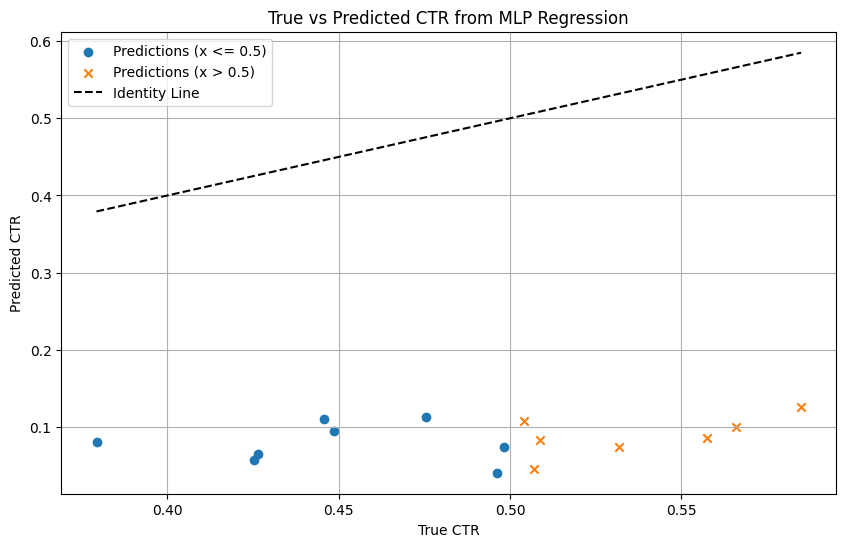

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Assuming reg, test_landmarks_reshape, val_landmarks_reshape, test_CTR, and val_CTR are already defined

# Predictions
reg_pred = reg_mlp.predict(test_landmarks_reshape)
reg_pred_val = reg_mlp.predict(val_landmarks_reshape)

# R2 scores
r2 = r2_score(test_CTR, reg_pred)
r2_val = r2_score(val_CTR, reg_pred_val)
print('R2:', r2)
print('R2_val:', r2_val)


# Mean Squared Error
mse = mean_squared_error(test_CTR, reg_pred)
print('MSE:', mse)

# Scatter plot of true vs. predicted CTR
plt.figure(figsize=(10, 6))

# Plot points with x values <= 0.5
mask_under_0_5 = test_CTR <= 0.5
plt.scatter(test_CTR[mask_under_0_5], reg_pred[mask_under_0_5], label='Predictions (x <= 0.5)')

# Plot points with x values > 0.5
mask_over_0_5 = test_CTR > 0.5
plt.scatter(test_CTR[mask_over_0_5], reg_pred[mask_over_0_5],  label='Predictions (x > 0.5)', marker='x')

# Plot identity line in black
plt.plot([min(test_CTR), max(test_CTR)], [min(test_CTR), max(test_CTR)], 'k--', label='Identity Line')

plt.xlabel('True CTR')
plt.ylabel('Predicted CTR')
plt.title('True vs Predicted CTR from MLP Regression')
plt.legend()
plt.grid(True)
plt.show()

# Regression on output of lungs from diffrent models 

In [67]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip


In [68]:
from models.unet import UNet

modelUNet = UNet(n_classes = 3).to(device)
modelUNet.load_state_dict(torch.load('../TrainingSave/Lung/Unetlungs500epochs/bestDice_0.pt'))
modelUNet.eval()
print('Model loaded')

Model loaded


In [69]:
A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [120, 120, 120, 60, 60, 60]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = [1024, 1024]

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 6
config['l2'] = 5

double65 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
# double65.load_state_dict(torch.load("../weights_extended/double_65_ext/bestMSE.pt"))
double65.load_state_dict(torch.load("../TrainingSave/Lung/JSRTLungDataHybridDoubleSkip500epocs/bestMSE.pt"))
double65.eval()
print('Model loaded')

[32, 32]
6-5
Model loaded


In [70]:
from models.unet import UNet

unet = UNet(n_classes = 3).to(device)
unet.load_state_dict(torch.load('../TrainingSave/Lung/Unetlungs500epochs/bestDice_0.pt'))

unet.eval()

print('Model loaded')

Model loaded


In [71]:
from medpy.metric import dc, hd, assd, jc
from utils.fun import reverseVector, drawBinary
import matplotlib.pyplot as plt



def evalImageMetrics(blank, output, target_lungs, target_heart):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)
    
    hdp = hd(ptest, target_lungs, voxelspacing = 0.35)
    dcp = dc(ptest, target_lungs)

    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), h)
    
    hdc = hd(ptest, target_heart, voxelspacing = 0.35)
    dcc = dc(ptest, target_heart)
    
    return [dcp, dcc, hdp, hdc]


# def evalImageMetrics(blank, output, target):
#     p1, p2, h, c1, c2 = reverseVector(output)
    
#     t_lungs = np.logical_or(target == 1, target == 2)

#     ptest = drawBinary(blank.copy(), p1)
#     ptest = drawBinary(ptest, p2)
    
#     hdp = hd(ptest, t_lungs)
#     dcp = dc(ptest, t_lungs)
#     ptest = drawBinary(blank.copy(), h)

#     hdc = hd(ptest, target == 3)
#     dcc = dc(ptest, target == 3)

#     return [dcp, hdp, dcc, hdc]



def evalImageMetricsUNet(output, target):
    t_lungs = np.logical_or(target == 1, target == 2)
    dcp = dc(output == 1, t_lungs)
    dcc = dc(output == 2, target == 3)
    
    hdp = hd(output == 1, t_lungs)
    hdc = hd(output == 2, target == 3)
    
    return [dcp, hdp, dcc, hdc]

In [72]:
import pandas as pd


model_list = [double65]
model_names = ['2-SC Layers 6-5']


blank = np.zeros([1024, 1024])

results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()
        
        p1, p2, h, c1, c2 = reverseVector(target * 1024)
       
        t_lungs = drawBinary(blank.copy(), p1)
        t_lungs = drawBinary(t_lungs, p2)
        t_heart = drawBinary(blank.copy(), h)
             
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
                
            output = output.cpu().numpy().reshape(-1) 
            
            metrics = evalImageMetrics(blank, output * 1024, t_lungs, t_heart)
                     
            aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])
            results = results.append(aux, ignore_index = True)
        
        

 15 of 15

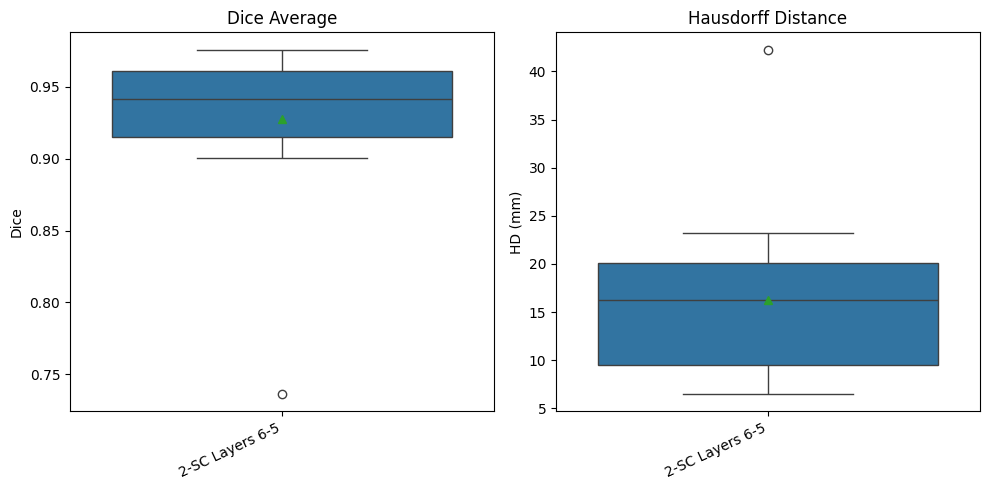

Dice
2-SC Layers 6-5 0.927 +- 0.056

Hausdorff
2-SC Layers 6-5 16.243 +- 8.745



In [73]:
import matplotlib.ticker as mticker
import seaborn as sns

results['Dice Average'] = results[['Dice Lungs', 'Dice Heart']].mean(axis=1)
results['HD Average'] = results[['HD Lungs', 'HD Heart']].mean(axis=1)

plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice')
plt.title('Dice Average')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num3.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Average'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Average'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Average'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Average'][results['Model'] == model]))

print('')

In [74]:
def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]


In [75]:
data_root = pathlib.Path(test_path)
all_files = list(data_root.glob('*.png'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

print(test_path)
print(len(all_files))

../Datasets/PadJSRTClassification/test
0


In [76]:
from utils.fun import drawOrgans
import cv2
import numpy as np
import pandas as pd

results = pd.DataFrame()
blank = np.zeros([1024, 1024])

i = 0
for sample in all_files:
    # print(sample)
    with torch.no_grad():
        img = cv2.imread(sample, 0) / 255
        data = np.expand_dims(img, axis = 0)
        data = np.expand_dims(data, axis = 0)
        data = torch.tensor(data).to(device).float()
        
        # gt_file = sample.replace('Images','Masks')
        # print("GT file:", gt_file)
        gt = cv2.imread(sample.replace('Images','Masks'), cv2.IMREAD_UNCHANGED)


        output = double65(data)
        if len(output) > 1:
            output = output[0]
            
        output = output.cpu().numpy().reshape(-1) 
        output = np.clip(output, 0, 1)[:240]

        metrics = evalImageMetrics(blank, output * 1024, gt)
             
        aux = pd.DataFrame([['HybridGNet 2-IGSC'] + metrics[:2] + ['Lungs']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        aux = pd.DataFrame([['HybridGNet 2-IGSC'] + metrics[2:] + ['Heart']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        
        output = unet(data)
        output = torch.argmax(output[0,:,:,:], axis=0).cpu().numpy()
        
        metrics = evalImageMetricsUNet(output, gt)
        
        aux = pd.DataFrame([['UNet'] + metrics[:2] + ['Lungs']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        aux = pd.DataFrame([['UNet'] + metrics[2:] + ['Heart']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        

        i = i+1

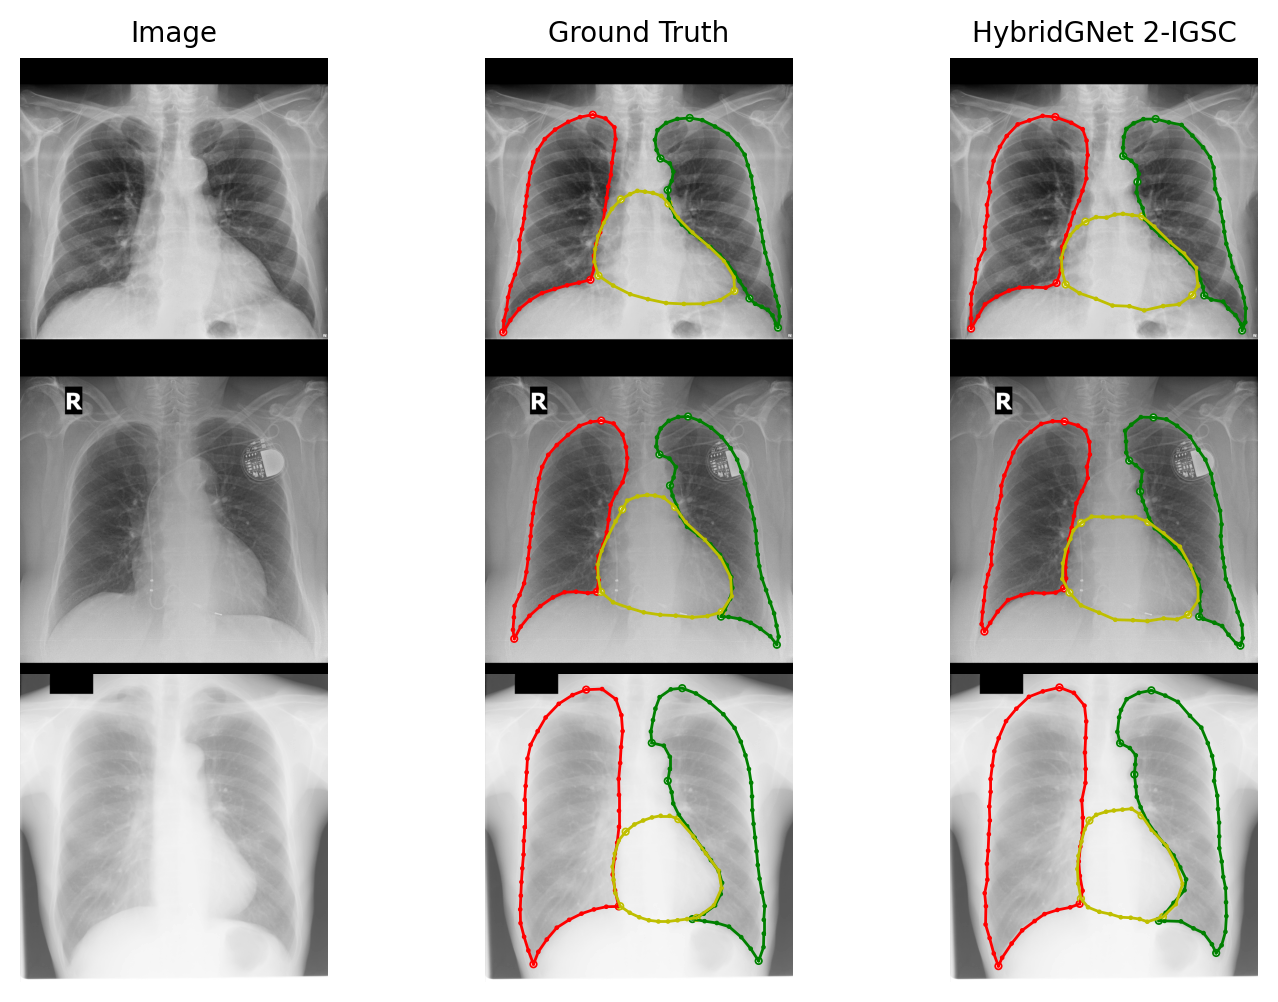

In [77]:
# indx = [1,4,8]
indx = [1,2,12]

plt.figure(figsize = (9,6), dpi = 200)

for j in range(0,3):
    i = indx[j]
    with torch.no_grad():
        # sample = test_dataset[i]
        data = test_dataset[i]['image'] 
        target = test_dataset[i]['landmarks'][:120]
        data = torch.unsqueeze(data, 0).to(device)
        target = target.reshape(-1).numpy()

        ax = plt.subplot(3, 3, 1+ j*3)
        plt.axis('off')
        
        draw = data.cpu().numpy()[0,0,:,:]
        if j==0:
            plt.title('Image', fontsize=10)
        plt.imshow(data.cpu().numpy()[0,0,:,:], cmap = 'gray')
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)

        ax = plt.subplot(3, 3, 2+j*3)
        plt.axis('off')
       
        
        drawOrgans(ax, target*1024, None, draw.copy())
        if j==0:
            plt.title('Ground Truth', fontsize=10)
        # plt.imshow(img, cmap = 'gray')

        plt.xlim(1, 1024)
        plt.ylim(1024, 1)
        
        ax = plt.subplot(3, 3, 3+j*3)
        plt.axis('off')
                         
        output = double65(data)
        if len(output) > 1:
            output = output[0]
            
        output = output.cpu().numpy().reshape(-1) 
        output = np.clip(output, 0, 1)[:240]

        drawOrgans(ax, output * 1024, None, draw.copy())
        if j==0:
            plt.title('HybridGNet 2-IGSC', fontsize=10)
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)


plt.subplots_adjust(wspace=0, hspace=0)

In [78]:
outputs = []
for i in range(70):
    with torch.no_grad():
        data = train_dataset[i]['image'] 
        data = torch.unsqueeze(data, 0).to(device)
        output = double65(data)
        if len(output) > 1:
            output = output[0]
        output = output.cpu().numpy().reshape(-1) 
        output = np.clip(output, 0, 1)[:240]
        outputs.append(output)

outputs = np.array(outputs)
print(outputs.shape)


(70, 240)


In [79]:
test_outputs = []
for i in range(15):
    with torch.no_grad():
        data = test_dataset[i]['image'] 
        data = torch.unsqueeze(data, 0).to(device)
        output = double65(data)
        if len(output) > 1:
            output = output[0]
        output = output.cpu().numpy().reshape(-1) 
        output = np.clip(output, 0, 1)[:240]
        test_outputs.append(output)

test_outputs = np.array(test_outputs)
print(test_outputs.shape)


(15, 240)


In [80]:
output_70_120_2 = test_outputs.reshape(15, 120, 2)
print(output_70_120_2.shape)

(15, 120, 2)


In [89]:
print(test_landmarks.shape)

test_right_lung = output_70_120_2[:,:44,:]
test_left_lung = output_70_120_2[:,44:94:,]
test_heart = output_70_120_2[:,94:,:]

print(test_right_lung.shape)
print(test_left_lung.shape)
print(test_heart.shape)
test_right_lung = torch.tensor(test_right_lung).to(device)
test_left_lung = torch.tensor(test_left_lung).to(device)
test_heart = torch.tensor(test_heart).to(device)

torch.Size([15, 120, 2])
(15, 44, 2)
(15, 50, 2)
(15, 26, 2)


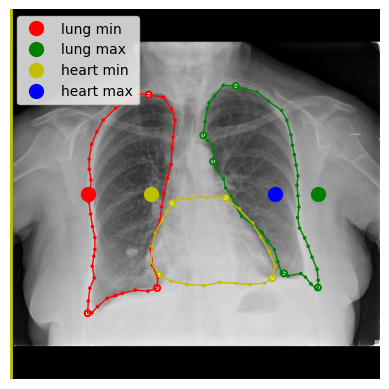

In [94]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches



# Choose the index of the image you're interested in
image_index = 0

lung_image = test_dataset[image_index]['image'][0]

# Assuming the x-coordinates are at even indices and y-coordinates are at odd indices
right_lung_x = test_right_lung[image_index].view(-1)[::2]
left_lung_x = test_left_lung[image_index].view(-1)[::2]

lung_min_x = min(torch.min(right_lung_x), torch.min(left_lung_x))
lung_max_x = max(torch.max(right_lung_x), torch.max(left_lung_x))

# Find min and max for the right lung, left lung, and heart of the chosen image
# lung_min_x = min(torch.min(test_right_lung[image_index].view(-1)), torch.min(test_left_lung[image_index].view(-1)))
# lung_max_x = max(torch.max(test_right_lung[image_index].view(-1)), torch.max(test_left_lung[image_index].view(-1)))

heart_min_x = torch.min(test_heart[image_index].view(-1)[::2])
heart_max_x = torch.max(test_heart[image_index].view(-1)[::2])

# Assuming `lung_image` is your lung image
# plt.imshow(lung_image, cmap='gray')

# Create rectangles for the min and max x-coordinates of the lungs
rect_lung_min = patches.Rectangle((lung_min_x, 0), width=1, height=lung_image.shape[0], linewidth=2, edgecolor='r', facecolor='none')
rect_lung_max = patches.Rectangle((lung_max_x, 0), width=1, height=lung_image.shape[0], linewidth=2, edgecolor='b', facecolor='none')

# Create rectangles for the min and max x-coordinates of the heart
rect_heart_min = patches.Rectangle((heart_min_x, 0), width=1, height=lung_image.shape[0], linewidth=2, edgecolor='g', facecolor='none')
rect_heart_max = patches.Rectangle((heart_max_x, 0), width=1, height=lung_image.shape[0], linewidth=2, edgecolor='y', facecolor='none')

# Add the rectangles to the plot
plt.gca().add_patch(rect_lung_min)
plt.gca().add_patch(rect_lung_max)
plt.gca().add_patch(rect_heart_min)
plt.gca().add_patch(rect_heart_max)

# Set plot limits
plt.xlim(0, lung_image.shape[1])
plt.ylim(lung_image.shape[0], 0)  # Note: y values are inverted in image coordinates

# Plot points for the min and max x-coordinates of the lungs
plt.plot(lung_min_x*1024, lung_image.shape[0] // 2, 'ro', markersize=10, label='lung min')  # red point
plt.plot(lung_max_x*1024, lung_image.shape[0] // 2, 'go', markersize=10, label='lung max')  # blue point

# Plot points for the min and max x-coordinates of the heart
plt.plot(heart_min_x*1024, lung_image.shape[0] // 2, 'yo', markersize=10, label = 'heart min')  # green point
plt.plot(heart_max_x*1024, lung_image.shape[0] // 2, 'bo', markersize=10, label='heart max')  # yellow point
plt.legend()
plt.axis('off')

# Existing code
from utils.fun import drawOrgans
device = torch.device('cpu')

img1 = test_dataset[image_index]['image']
# lm = test_dataset[image_index]['landmarks'][:120]
# target = lm.reshape(-1).numpy()
target = test_outputs[image_index].reshape(-1)

data = torch.unsqueeze(img1, 0).to(device)
draw = data.cpu().numpy()[0,0,:,:]
ax = plt.subplot(1, 1, 1)

img2 = drawOrgans(ax, target*1024, None, draw)


In [30]:
unetoutputs = []
for i in range(70):
    with torch.no_grad():
        data = train_dataset[i]['image'] 
        data = torch.unsqueeze(data, 0).to(device)
        output = modelUNet(data)
        output = torch.argmax(output[0,:,:,:], axis=0).cpu().numpy()
        unetoutputs.append(output)

unetoutputs = np.array(unetoutputs)
print(unetoutputs.shape)

(70, 1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

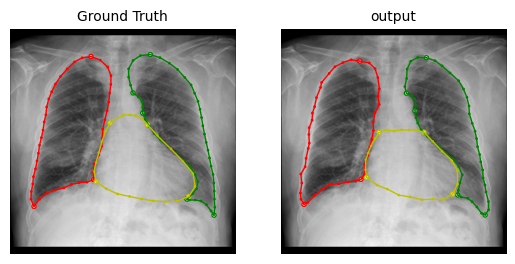

In [36]:
n = 3

data = train_dataset[n]['image']
lm = train_dataset[n]['landmarks'][:120]
data = torch.unsqueeze(data, 0).to(device)

draw = data.cpu().numpy()[0,0,:,:]

ax = plt.subplot(1, 2, 1)
drawOrgans(ax, lm * 1024, None, draw.copy())
plt.title('Ground Truth', fontsize=10)
plt.axis('off')

ax = plt.subplot(1, 2, 2)
drawOrgans(ax, outputs[n] * 1024, None, draw.copy())
plt.title('output', fontsize=10)
plt.axis('off')


In [37]:
test_output = []
for i in range(15):
    with torch.no_grad():
        data = test_dataset[i]['image'] 
        data = torch.unsqueeze(data, 0).to(device)
        output = double65(data)
        if len(output) > 1:
            output = output[0]
        output = output.cpu().numpy().reshape(-1) 
        output = np.clip(output, 0, 1)[:240]
        test_output.append(output)

In [38]:
val_output = []
for i in range(15):
    with torch.no_grad():
        data = val_dataset[i]['image'] 
        data = torch.unsqueeze(data, 0).to(device)
        output = double65(data)
        if len(output) > 1:
            output = output[0]
        output = output.cpu().numpy().reshape(-1)
        output = np.clip(output, 0, 1)[:240]
        val_output.append(output)
        

In [49]:
train_out = outputs.reshape(70, 120,2)
print(train_out.shape)
print(type(train_landmarks))
train_out = torch.tensor(train_out).to(device)
print(type(train_out))


(70, 120, 2)
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [50]:
train_right_lung = train_out[:,:44,:]
train_left_lung =train_out[:,44:94:,] 
train_heart = train_out[:,94:,:]

# Assuming the x-coordinates are at index 0 after reshaping
right_lung_x = train_right_lung.view(train_right_lung.shape[0], -1)[:, ::2]
left_lung_x = train_left_lung.view(train_left_lung.shape[0], -1)[:, ::2]

lung_min_x = torch.min(torch.min(right_lung_x, dim=1).values, torch.min(left_lung_x, dim=1).values)
lung_max_x = torch.max(torch.max(right_lung_x, dim=1).values, torch.max(left_lung_x, dim=1).values)

# heart_min_x = torch.min(train_heart, dim=1).values[:, 0]
# heart_max_x = torch.max(train_heart, dim=1).values[:, 0]
heart_min_x = torch.min(train_heart, dim=1).values.view(-1)[::2]
heart_max_x = torch.max(train_heart, dim=1).values.view(-1)[::2]


# Calculate the maximum horizontal distances
lung_distance = lung_max_x - lung_min_x
heart_distance = heart_max_x - heart_min_x

# Calculate CTR
Outputs_train_CTR = heart_distance / lung_distance


In [51]:
print(Outputs_train_CTR)

tensor([0.5169, 0.5356, 0.5228, 0.4897, 0.4696, 0.4765, 0.4988, 0.5041, 0.5559,
        0.5778, 0.5326, 0.5341, 0.5515, 0.5255, 0.5515, 0.4918, 0.5284, 0.6042,
        0.5467, 0.5158, 0.5352, 0.5060, 0.5828, 0.5382, 0.5118, 0.5079, 0.6045,
        0.4299, 0.4832, 0.4764, 0.5888, 0.4784, 0.5306, 0.3775, 0.5460, 0.5497,
        0.5478, 0.4263, 0.4469, 0.4314, 0.5527, 0.5491, 0.4616, 0.4014, 0.4140,
        0.4388, 0.4534, 0.4780, 0.4619, 0.4357, 0.4201, 0.4246, 0.4326, 0.5070,
        0.4484, 0.4552, 0.5283, 0.4736, 0.4761, 0.3684, 0.4399, 0.4670, 0.3694,
        0.5031, 0.5298, 0.4278, 0.4946, 0.4658, 0.4608, 0.4306])


In [32]:
from sklearn.linear_model import LinearRegression

# reg_out = LinearRegression().fit(outputs, Outputs_train_CTR)
reg_out = LinearRegression().fit(outputs, train_CTR)


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error


# Assuming reg, test_landmarks_reshape, val_landmarks_reshape, test_CTR, and val_CTR are already defined

# Predictions
reg_pred = reg_out.predict(test_landmarks_reshape)


r2 = r2_score(test_CTR, reg_pred)
print('R2_test:', r2)

r2_val = r2_score(val_CTR, reg_out.predict(val_landmarks_reshape))
print('R2_val:', r2_val)

print("predicitons", reg_pred)
print("true", test_CTR)

mse = mean_squared_error(test_CTR, reg_pred)
print('MSE:', mse)

mse_val = mean_squared_error(val_CTR, reg_out.predict(val_landmarks_reshape))
print('MSE_val:', mse_val)

plt.figure(figsize=(10, 6))

mask_under_0_5 = test_CTR <= 0.5
plt.scatter(test_CTR[mask_under_0_5], reg_pred[mask_under_0_5], label='Predictions (x <= 0.5)')

mask_over_0_5 = test_CTR > 0.5
plt.scatter(test_CTR[mask_over_0_5], reg_pred[mask_over_0_5],  label='Predictions (x > 0.5)', marker='x')

plt.plot([min(test_CTR), max(test_CTR)], [min(test_CTR), max(test_CTR)], 'k--', label='Identity Line')

plt.xlabel('True CTR')
plt.ylabel('Predicted CTR')
plt.title('True vs Predicted CTR from Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

TypeError: too many positional arguments

In [ ]:
from sklearn import tree
reg_out_tree = tree.DecisionTreeRegressor().fit(outputs, train_CTR)

from sklearn.neural_network import MLPRegressor
reg_out_mlp = MLPRegressor(random_state=1, max_iter=500).fit(outputs, train_CTR)